In [43]:
#download dataset 
from google.colab import files
files.upload() # upload downloaded kaggle.json 
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d jonathanoheix/face-expression-recognition-dataset
# unzip data
!mkdir -p input
!unzip face-expression-recognition-dataset -d input/

Streaminguitvoer ingekort tot de laatste 5000 regels.
  inflating: input/images/validation/fear/8797.jpg  
  inflating: input/images/validation/fear/8818.jpg  
  inflating: input/images/validation/fear/886.jpg  
  inflating: input/images/validation/fear/9037.jpg  
  inflating: input/images/validation/fear/9040.jpg  
  inflating: input/images/validation/fear/9101.jpg  
  inflating: input/images/validation/fear/911.jpg  
  inflating: input/images/validation/fear/9179.jpg  
  inflating: input/images/validation/fear/9205.jpg  
  inflating: input/images/validation/fear/9232.jpg  
  inflating: input/images/validation/fear/9251.jpg  
  inflating: input/images/validation/fear/9261.jpg  
  inflating: input/images/validation/fear/9281.jpg  
  inflating: input/images/validation/fear/9302.jpg  
  inflating: input/images/validation/fear/9333.jpg  
  inflating: input/images/validation/fear/9369.jpg  
  inflating: input/images/validation/fear/9370.jpg  
  inflating: input/images/validation/fear/9474.

We will be training our model for the following 5 emotions:


*   Happy
*   Sad
*   Angry
*   Neutral
*   Surprise



Remove fear and disgust from the dataset.

In [44]:
!rm -rf "./input/images/train/fear/"
!rm -rf "./input/images/train/disgust/"

In [45]:
!rm -rf "./input/images/validation/fear/"
!rm -rf "./input/images/validation/disgust/"

Each image is grey-scaled and of resolution 48x48.

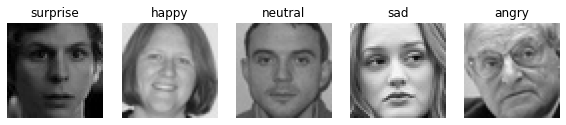

In [46]:
import numpy as np
import seaborn as sns
from keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import os

# size of the image: 48*48 pixels
pic_size = 48

# input path for the images
base_path = "./input/images/"

train_data_dir = base_path +'train/'
validation_data_dir = base_path + 'validation/'

plt.figure(figsize=(14,22))
i = 1
for expression in os.listdir(train_data_dir):
    img = load_img((train_data_dir + expression +'/'+ os.listdir(train_data_dir + expression)[1]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1
plt.show()


We check the number of images for training.

In [47]:
nb_train_samples = 0
for expression in os.listdir(train_data_dir):
    nb_train_samples += len(os.listdir(train_data_dir + "/" + expression))
print(nb_train_samples)

24282


We check the number of images for validation.

In [48]:
nb_validation_samples = 0
for expression in os.listdir(validation_data_dir):
    nb_validation_samples += len(os.listdir(validation_data_dir + "/" + expression))
print(nb_validation_samples)

5937


We check the number of emotion categories we have and the number of images in each of those categories.

In [49]:
import pandas as pd

def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + "/"+ expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
train_count = count_exp(train_data_dir, 'train')
print(train_count)

       surprise  happy  neutral   sad  angry
train      3205   7164     4982  4938   3993


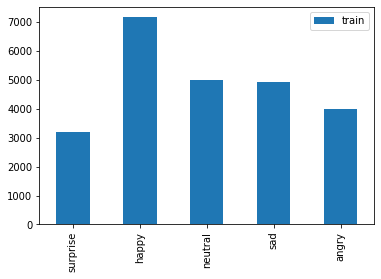

In [50]:
train_count.transpose().plot(kind='bar')

Data Augmentation:


*   Rescaling 
*   Rotation 
*   Shear
*   Width range 
*   Height range
*   Horizontal flip 
*   Zoom 


In [51]:
num_classes = 5
img_rows,img_cols = 48,48
batch_size = 32

In [52]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=30,
                    shear_range=0.3,
                    zoom_range=0.3,
                    width_shift_range=0.4,
                    height_shift_range=0.4,
                    horizontal_flip=True,
                    fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
                    train_data_dir,
                    color_mode='grayscale',
                    target_size=(img_rows,img_cols),
                    batch_size=batch_size,
                    class_mode='categorical',
                    shuffle=True)

validation_generator = validation_datagen.flow_from_directory(
                            validation_data_dir,
                            color_mode='grayscale',
                            target_size=(img_rows,img_cols),
                            batch_size=batch_size,
                            class_mode='categorical',
                            shuffle=True)

Found 24282 images belonging to 5 classes.
Found 5937 images belonging to 5 classes.


In [53]:
train_generator.class_indices

{'angry': 0, 'happy': 1, 'neutral': 2, 'sad': 3, 'surprise': 4}

Modeling: 

*   Optimizing the model using relu activation function. 
*   Doubling the number of kernels as 32, 64, 128, and 256.
*   For generalization purpose dropouts are used at regular intervals.
*   Batch Normalization is also used for better results


In [54]:
from keras.models import Sequential
from keras.layers import Dense,Dropout,Activation,Flatten,BatchNormalization
from keras.layers import Conv2D,MaxPooling2D
from keras.optimizers import RMSprop,SGD,Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Initialising the CNN
model = Sequential()

model.add(Conv2D(32,(3,3),padding='same',kernel_initializer='he_normal',input_shape=(img_rows,img_cols,1)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(64,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(128,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(256,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(64,kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(num_classes,kernel_initializer='he_normal'))
model.add(Activation('softmax'))

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 48, 48, 32)        320       
_________________________________________________________________
activation (Activation)      (None, 48, 48, 32)        0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 48, 48, 32)        128       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 24, 24, 32)        0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 24, 24, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 24, 24, 64)        0

In [55]:
# compile the model using Adam optimize

model.compile(loss='categorical_crossentropy',
              optimizer = Adam(lr=0.001),
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Saving model using ModelCheckpoint, EarlyStopping for avoiding over-fitting and ReduceLROnPlateu for reducing learning rate whenever the validation accuracy plateaus occurs.

In [56]:
checkpoint = ModelCheckpoint('face_emotion.h5',
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001)

callbacks = [earlystop,checkpoint,reduce_lr]


epochs=50

## train the model 

history=model.fit(
                train_generator,
                steps_per_epoch=nb_train_samples//batch_size,
                epochs=epochs,
                callbacks=callbacks,
                validation_data=validation_generator,
                validation_steps=nb_validation_samples//batch_size)

Epoch 1/50
758/758 [==============================] - 227s 261ms/step - loss: 2.0428 - accuracy: 0.2312 - val_loss: 1.5341 - val_accuracy: 0.2995

Epoch 00001: val_loss improved from inf to 1.53414, saving model to face_emotion.h5
Epoch 2/50
758/758 [==============================] - 196s 258ms/step - loss: 1.5815 - accuracy: 0.2854 - val_loss: 1.5899 - val_accuracy: 0.3096

Epoch 00002: val_loss did not improve from 1.53414
Epoch 3/50
758/758 [==============================] - 196s 258ms/step - loss: 1.5507 - accuracy: 0.3053 - val_loss: 2.2256 - val_accuracy: 0.3167

Epoch 00003: val_loss did not improve from 1.53414
Epoch 4/50
758/758 [==============================] - 196s 258ms/step - loss: 1.5389 - accuracy: 0.3078 - val_loss: 1.4725 - val_accuracy: 0.3500

Epoch 00004: val_loss improved from 1.53414 to 1.47248, saving model to face_emotion.h5
Epoch 5/50
758/758 [==============================] - 197s 260ms/step - loss: 1.5267 - accuracy: 0.3145 - val_loss: 1.4003 - val_accuracy:

In [57]:
model.save_weights("face_emotion.h5")


Plot the training and validation metrics

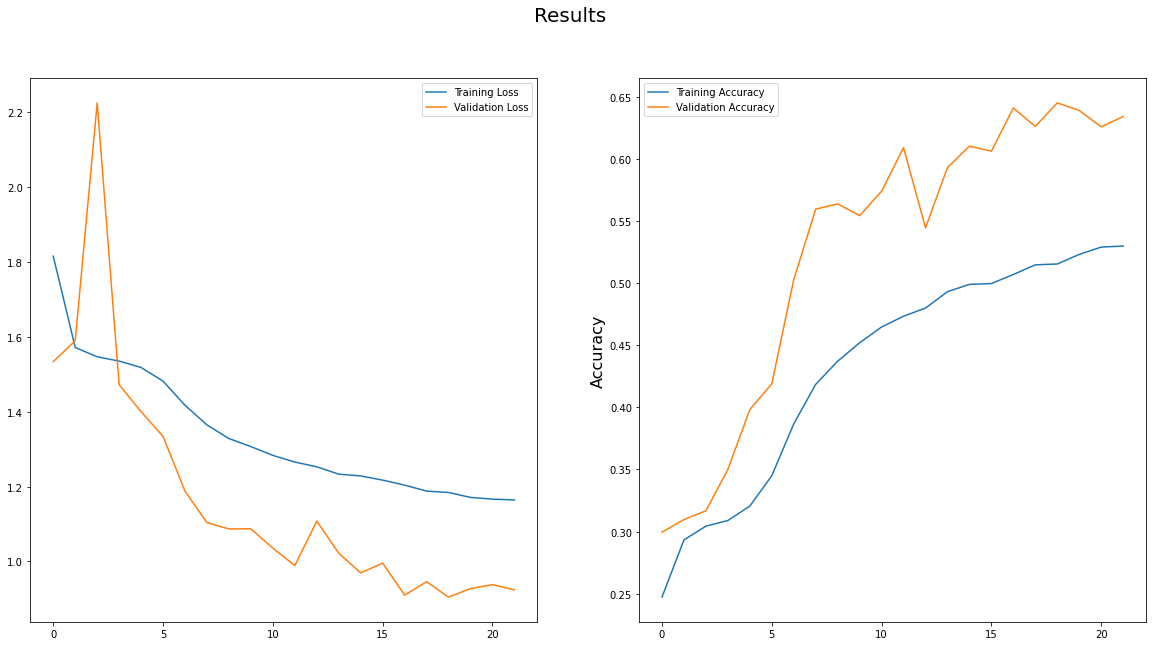

In [58]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.suptitle('Results',fontsize=20)
plt.plot(history.history['loss'],label='Training Loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.legend(loc='upper right')
plt.subplot(1,2,2)
plt.ylabel("Accuracy",fontsize=16)
plt.plot(history.history['accuracy'],label='Training Accuracy')
plt.plot(history.history['val_accuracy'],label = 'Validation Accuracy')
plt.legend()
plt.show()

Save model for latter use.

In [59]:
from google.colab import files
files.download('face_emotion.h5') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>